Kalman filter

Prediction step:
\begin{align}
x' & = F\hat{x} + Bu + v \\
P' & = F\hat{P}F^T + Q \\
\end{align}

Where:
- x' - predicted value
- F - state transition matrix
- B - control input matrix
- u - control vector
- v - process noise, can be equal 0
- P' - predicted covariance
- Q - noise


Measurement update:
\begin{align}
y & = z - Hx' \\
S & = HP'H^T + R \\
K & = P'H^TS^{-1} \\
x & = x' + Ky \\
P & = (I - KH)P' \\
\end{align}

Where:
- z - actual measurement 
- H - state transition matrix 
- y - difference between measured value and actual value
- R - measurement noise
- K - Kalman gain
- S - total error


In [13]:
import numpy as np
from numpy.linalg import inv

class KalmanFilter:
    def __init__(self, dim_x, dim_z):
        self.x = np.zeros((dim_x, 1)) 
        self.P = np.eye(dim_x)           
        self.Q = np.eye(dim_x)             
        self.B = 0                    
        self.F = np.eye(dim_x)              
        self.H = np.zeros((dim_z, dim_x))    
        self.R = np.eye(dim_z)               
        self.M = np.zeros((dim_x, dim_z)) 
        self.z = np.array([[None]*dim_z]).T
        self.I = np.eye(dim_x)

    def predict(self, u=0):
        if u == 0:
            self.x = self.F @ self.x
        else:
            self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q

        return self.x.copy(), self.P.copy()

    def update(self, z):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ inv(S)
        self.x = self.x + K @ y
        self.P = (self.I - K @ self.H) @ self.P
        return self.x.copy(), self.P.copy()

Example

In [62]:
import random
import numpy as np


def rand():
    return random.random() - 0.5


def get_measuerment(x, factor=0.1):
    z = [
        x[0] + rand() * factor,
        x[2] + rand() * factor,
    ]
    return z


class SensorSim:
    def __init__(self, x=0, y=0, dx=0.1, dy=0.1):
        self.x = x
        self.y = y
        self.dx = dx
        self.dy = dy

    def sense(self, dt=1):
        self.x += self.dx + dt
        self.y += self.dy + dt
        return self.x, self.y

    def sense_with_noise(self, dt=1, noise_factor=0.1):
        sens = self.sense(dt)
        z = [
            sens[0] + rand() * noise_factor,
            sens[1] + rand() * noise_factor,
        ]
        return z

    def get_real(self):
        return self.x, self.y


def get_kalman_filter(dt=1, p_magnitude=10, q_noise=1):
    kf = KalmanFilter(4, 2)
    kf.P = kf.P * p_magnitude
    kf.x = np.asarray([0, 0.1, 0, 0.1])
    kf.F = np.array([[1, dt, 0,  0],
                     [0,  1, 0,  0],
                     [0,  0, 1, dt],
                     [0,  0, 0,  1]])
    kf.Q = [[0, 0.001*q_noise, 0, 0],
            [0.001*q_noise, 0.001*q_noise, 0, 0],
            [0, 0, 0, 0.001*q_noise],
            [0, 0, 0.001*q_noise, 0.001*q_noise]]

    kf.H = np.array([[1, 0, 0, 0],
                     [0, 0, 1, 0]])

    kf.R = np.array([[5., 0],
                     [0, 5]])

    return kf


kf = get_kalman_filter(p_magnitude=2, q_noise=0.1)

xs = list()
rxs = list()
zs = list()

s = SensorSim()

for _ in range(10):
    x_pred, _ = kf.predict()
    z = s.sense_with_noise(noise_factor=.9)
    rx = s.get_real()
    x_update, _ = kf.update(z)
    xs.append(x_update)
    zs.append(z)
    rxs.append(rx)
    print(x_pred, x_update)
xs = np.array(xs)
zs = np.array(zs)
rxs = np.array(rxs)


[0.1 0.1 0.1 0.1] [0.48881358 0.29441651 0.70161516 0.40082262]
[0.78323009 0.29441651 1.10243778 0.40082262] [1.7439967  0.72144583 1.59228263 0.61854263]
[2.46544253 0.72144583 2.21082526 0.61854263] [2.6826649  0.79747912 2.80932352 0.82803205]
[3.48014402 0.79747912 3.63735557 0.82803205] [3.90317371 0.91728992 4.2180103  0.99248554]
[4.82046363 0.91728992 5.21049584 0.99248554] [5.26550445 1.02271766 5.28462602 1.01004658]
[6.28822211 1.02271766 6.2946726  1.01004658] [6.30721951 1.02658302 6.28789679 1.00866792]
[7.33380253 1.02658302 7.2965647  1.00866792] [7.55745374 1.06647208 7.5720603  1.05780362]
[8.62392582 1.06647208 8.62986392 1.05780362] [8.80263425 1.09485742 8.67180391 1.0644652 ]
[9.89749166 1.09485742 9.73626911 1.0644652 ] [9.81497406 1.08303704 9.72920629 1.06345347]
[10.8980111   1.08303704 10.79265976  1.06345347] [10.9127475   1.08496038 10.77116307  1.0606478 ]


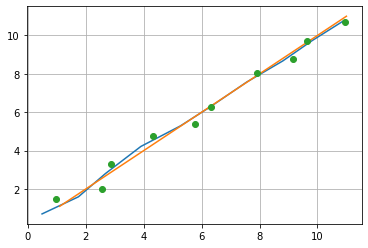

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = plt.axes()
ax.plot(xs[:, 0], xs[:, 2])
ax.plot(rxs[:, 0], rxs[:, 1])
ax.plot(zs[:, 0], zs[:, 1], 'o')
plt.grid()
plt.show()

References: <br>
1) [Kalman Filter Interview](https://towardsdatascience.com/kalman-filter-interview-bdc39f3e6cf3) <br>
2) [Kalman Filter book](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) <br>